## CPC Overview - 日本政治言説シミュレーション

This notebook implements an advanced information diffusion model using Large Language Model (LLM) agents with **Consensus-based Posterior Computation (CPC)** theory for belief updates, specifically focused on Japanese political discourse about Ministry of Finance (財務省) policies.

### Mathematical Foundation

$$p(w_d | O^{1:N}, S) = \prod_{k=1}^{N_h+N_a} p(o_d^k | w_d, z_d^k) p(z_d^k | \theta^k) p(w_d | S)$$

Where:
- $w_d$: Candidate representation/belief
- $O^{1:N}$: Set of observations from all agents
- $S$: Safety constraints
- $o_d^k$: Observation from agent k
- $z_d^k$: Latent variable for agent k
- $\theta^k$: Parameters for agent k
- $N_h + N_a$: Total number of human and AI agents

### Key Features

- **Japanese Political Discourse**: All agents communicate in Japanese about 財務省 policies
- **Polarized Groups**: Two opposing camps with strong views on Ministry of Finance
- **Viral Content Dynamics**: Tracking how provocative posts spread through polarized networks
- **CPC-Based Belief Updates**: Rigorous implementation of consensus-based posterior computation
- **Real LLM Integration**: Uses OpenAI GPT for authentic Japanese agent responses

## 1. Setup and Imports

In [1]:
# Core imports
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from datetime import datetime
import json
import time
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from IPython.display import display, HTML
import matplotlib.font_manager as fm

# OpenAI API - Modern v1.0+ syntax
from openai import OpenAI

# Set style with Japanese font support
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure matplotlib for Japanese
plt.rcParams['font.family'] = ['DejaVu Sans', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

print("✅ All imports successful!")
print("📊 Japanese font configuration applied")

✅ All imports successful!
📊 Japanese font configuration applied


## 2. OpenAI API Configuration

In [ ]:
# OpenAI API Setup
def setup_openai_client(api_key=None):
    """Initialize OpenAI client with modern API"""
    try:
        if api_key:
            client = OpenAI(api_key=api_key)
        else:
            api_key = os.getenv('OPENAI_API_KEY')
            if not api_key:
                api_key = input("Enter your OpenAI API key: ").strip()
            
            client = OpenAI(api_key=api_key)
        
        # Test the client
        test_response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[{"role": "user", "content": "こんにちは"}],
            max_tokens=10
        )
        print(f"✅ OpenAI API connected: {test_response.choices[0].message.content}")
        return client
        
    except Exception as e:
        print(f"❌ OpenAI API Error: {e}")
        raise

# Initialize the client
openai_client = setup_openai_client(api_key='')

✅ OpenAI API connected: こんにちは！😊  
今日はどんなご用件


## 3. CPC Theory Implementation

In [3]:
class CPCTheory:
    """Consensus-based Posterior Computation implementation"""
    
    def __init__(self, belief_dim=3, latent_dim=10, learning_rate=0.1):
        self.belief_dim = belief_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
    def compute_posterior(self, observations, agent_beliefs, agent_latents, safety_prior):
        """
        Compute posterior distribution over beliefs given observations
        """
        observations_tensor = torch.tensor(observations, dtype=torch.float32)
        beliefs_tensor = torch.tensor(agent_beliefs, dtype=torch.float32)
        latents_tensor = torch.tensor(agent_latents, dtype=torch.float32)
        
        # Ensure proper dimensions
        if observations_tensor.dim() > 1:
            observations_tensor = observations_tensor.squeeze()
        if beliefs_tensor.dim() > 1:
            beliefs_tensor = beliefs_tensor.squeeze()
        if latents_tensor.dim() > 1:
            latents_tensor = latents_tensor.squeeze()
        
        # Compute likelihood
        likelihood = self._compute_likelihood(observations_tensor, beliefs_tensor, latents_tensor)
        
        # Compute latent prior
        latent_prior = self._compute_latent_prior(latents_tensor)
        
        # Apply safety prior
        safety_prior_tensor = torch.tensor(safety_prior, dtype=torch.float32)
        
        # Compute posterior
        if likelihood.dim() == 0:
            log_posterior = likelihood + latent_prior + torch.log(safety_prior_tensor + 1e-8)
        else:
            log_posterior = likelihood + latent_prior + torch.log(safety_prior_tensor + 1e-8)
        
        posterior = F.softmax(log_posterior.view(-1), dim=-1)
        
        return posterior.numpy()
    
    def _compute_likelihood(self, observations, beliefs, latents):
        """Compute likelihood of observations given beliefs and latents"""
        if latents.dim() == 1:
            latent_contribution = 0.1 * latents[:self.belief_dim]
        else:
            latent_contribution = 0.1 * latents[:, :self.belief_dim]
        
        combined_state = beliefs + latent_contribution
        diff = observations - combined_state
        likelihood = -0.5 * torch.sum(diff ** 2, dim=-1)
        return likelihood
    
    def _compute_latent_prior(self, latents):
        """Compute prior over latent variables"""
        if latents.dim() == 1:
            return -0.5 * torch.sum(latents ** 2)
        else:
            return -0.5 * torch.sum(latents ** 2, dim=-1)
    
    def update_beliefs(self, current_beliefs, posterior, learning_rate=None):
        """Update beliefs using CPC posterior"""
        lr = learning_rate or self.learning_rate
        
        # Strong updates for political polarization
        gradient = posterior - current_beliefs
        new_beliefs = current_beliefs + lr * gradient * 2.0  # Amplified for stronger polarization
        
        return np.clip(new_beliefs, 0, 1)

## 4. Japanese Political CPC Agent

In [4]:
class JapanesePoliticalAgent:
    """CPC Agent for Japanese political discourse"""
    
    def __init__(self, agent_id, personality, initial_beliefs, openai_client, cpc_theory, group):
        self.agent_id = agent_id
        self.personality = personality
        self.beliefs = np.array(initial_beliefs)
        self.latent_state = np.random.randn(10) * 0.1
        self.client = openai_client
        self.cpc_theory = cpc_theory
        self.group = group  # 'pro_mof' or 'anti_mof'
        
        # Interaction history
        self.tweet_history = []
        self.observed_tweets = []
        self.quote_rt_history = []
        self.belief_history = [self.beliefs.copy()]
        
        # Network connections
        self.following = set()
        self.followers = set()
        
    def generate_tweet(self, topic, context="", max_retries=3):
        """Generate tweet in Japanese about MOF policies"""
        stance = "支持" if self.group == "pro_mof" else "反対"
        
        prompt = f"""あなたは{self.personality}です。財務省の{topic}について日本語でツイートしてください。
                    あなたの立場：財務省の政策に{stance}
                    信念の強さ（0-1）：
                    - 政府介入支持: {self.beliefs[0]:.2f}
                    - 個人の自由重視: {self.beliefs[1]:.2f}
                    - 経済的平等重視: {self.beliefs[2]:.2f}

                    コンテキスト: {context}

                    280文字以内で、あなたの立場を明確に示すツイートを作成してください。感情的で議論を呼ぶような内容にしてください。"""

        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model="gpt-4.1",
                    messages=[
                        {"role": "system", "content": f"あなたは{self.personality}で、財務省の政策に{stance}の立場です。"},
                        {"role": "user", "content": prompt}
                    ],
                    max_tokens=150,
                    temperature=0.9
                )
                
                content = response.choices[0].message.content.strip()
                if len(content) > 280:
                    content = content[:277] + "..."
                    
                return content
                
            except Exception as e:
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)
                else:
                    return self._fallback_tweet(topic)
    
    def should_quote_rt(self, tweet, author_agent, current_timestep=None):
        """Fixed version that accepts current_timestep parameter"""
        
        # Add tracking attributes if they don't exist
        if not hasattr(self, 'provocative_post_first_seen'):
            self.provocative_post_first_seen = None
        if not hasattr(self, 'provocative_post_qrt_count'):
            self.provocative_post_qrt_count = 0
        
        # Check if it's the provocative post
        if tweet.get('is_provocative', False):
            # Initialize first seen timestamp
            if self.provocative_post_first_seen is None:
                self.provocative_post_first_seen = current_timestep or tweet.get('timestamp', 0)
            
            # Calculate time since first seen
            time_elapsed = (current_timestep or tweet.get('timestamp', 0)) - self.provocative_post_first_seen
            
            # Time decay parameters
            if self.group == "pro_mof":
                initial_prob = 0.95
                decay_rate = 0.25
            else:
                initial_prob = 0.9
                decay_rate = 0.35
            
            min_prob = 0.05
            
            # Prevent re-QRTing too frequently
            if self.provocative_post_qrt_count > 0 and time_elapsed < 2:
                return False, 0.0
            
            # Calculate decayed probability
            current_prob = max(min_prob, initial_prob * np.exp(-decay_rate * time_elapsed))
            
            # Additional penalty for multiple QRTs
            if self.provocative_post_qrt_count > 0:
                current_prob *= (0.5 ** self.provocative_post_qrt_count)
            
            # Make decision
            should_qrt = np.random.random() < current_prob
            
            if should_qrt:
                self.provocative_post_qrt_count += 1
            
            return should_qrt, 0.0
        
        # Original logic for regular tweets
        alignment = np.dot(self.beliefs, author_agent.beliefs) / (
            np.linalg.norm(self.beliefs) * np.linalg.norm(author_agent.beliefs) + 1e-8
        )
        
        if self.group != author_agent.group:
            base_prob = 0.8
        else:
            base_prob = 0.4
        
        return np.random.random() < base_prob, alignment
    
    def generate_quote_rt(self, original_tweet, author_agent, alignment):
        """Generate quote RT in Japanese"""
        # Special handling for provocative post
        if original_tweet.get('is_provocative', False):
            stance_prompt = "強く支持" if self.group == "pro_mof" else "強く反対"
            emotion = "完全に同意！" if self.group == "pro_mof" else "絶対に許せない！"
        else:
            same_group = self.group == author_agent.group
            stance_prompt = "賛成" if same_group else "反対"
            emotion = "その通り！" if same_group else "それは違う！"
        
        prompt = f"""以下のツイートに対して引用リツイートを日本語で作成してください：
                    "{original_tweet['content']}"

                    あなたの立場：{stance_prompt}
                    感情的な反応：{emotion}

                    280文字以内で、強い感情を込めて引用リツイートしてください。議論を呼ぶような内容にしてください。"""

        try:
            response = self.client.chat.completions.create(
                model="gpt-4.1",
                messages=[
                    {"role": "system", "content": f"あなたは{self.personality}です。感情的に反応してください。"},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=1.0
            )
            
            content = response.choices[0].message.content.strip()
            if len(content) > 280:
                content = content[:277] + "..."
                
            return content
            
        except Exception as e:
            return self._fallback_quote_rt(same_group)
    
    def update_beliefs_cpc(self, all_tweets, all_quote_rts):
        """Update beliefs with polarization enhancement"""
        if not self.observed_tweets and not all_tweets:
            return
        
        # Extract observations
        observations = self._extract_observations(all_tweets, all_quote_rts)
        
        # Polarized safety prior
        if self.group == "pro_mof":
            safety_prior = np.array([0.8, 0.2, 0.6])  # Pro-government intervention
        else:
            safety_prior = np.array([0.2, 0.8, 0.4])  # Pro-individual freedom
        
        # Compute CPC posterior
        posterior = self.cpc_theory.compute_posterior(
            observations, 
            self.beliefs, 
            self.latent_state, 
            safety_prior
        )
        
        # Update beliefs
        self.beliefs = self.cpc_theory.update_beliefs(self.beliefs, posterior)
        self.belief_history.append(self.beliefs.copy())
        
        # Update latent state
        self.latent_state = 0.9 * self.latent_state + 0.1 * np.random.randn(10)
    
    def _extract_observations(self, all_tweets, all_quote_rts):
        """Extract belief observations from interactions"""
        obs = self.beliefs.copy()
        
        # Strong influence from group dynamics
        recent_qrts = [qrt for qrt in all_quote_rts[-10:]]
        
        for qrt in recent_qrts:
            if qrt['author'] == self.agent_id:
                # Reinforce beliefs when quote RTing
                if self.group == "pro_mof":
                    obs[0] += 0.1  # More pro-government
                else:
                    obs[1] += 0.1  # More pro-freedom
        
        return np.clip(obs, 0, 1)
    
    def _fallback_tweet(self, topic):
        """Fallback tweet generation"""
        if self.group == "pro_mof":
            return f"財務省の{topic}は日本の未来のために必要不可欠です。批判する人は大局を見ていない。#財務省支持"
        else:
            return f"財務省の{topic}は国民を苦しめるだけ。もっと自由な経済政策が必要だ。#財務省改革"
    
    def _fallback_quote_rt(self, same_group):
        """Fallback quote RT generation"""
        if same_group:
            return "完全に同意です！もっと多くの人がこの真実に気づくべき。"
        else:
            return "これは完全に間違っています。現実を見てください！"

## 5. Japanese Political Simulation Engine

In [5]:
class JapanesePoliticalSimulation:
    """Simulation engine for Japanese political discourse"""
    
    def __init__(self, agents, topic="増税政策"):
        self.agents = agents
        self.topic = topic
        self.all_tweets = []
        self.all_quote_rts = []
        self.network = nx.DiGraph()
        self.provocative_post = None
        self.provocative_post_qrts = []  # Track QRTs of the provocative post
        self.metrics = {
            'tweets': [],
            'quote_rts': [],
            'belief_variance': [],
            'network_density': [],
            'provocative_qrts': []  # New metric for viral tracking
        }
        self.provocative_post_first_seen = None  # Track when agent first saw the provocative post
        self.provocative_post_qrt_count = 0     # Track how many times agent QRT'd it
        
        # Initialize network
        for agent in agents:
            self.network.add_node(agent.agent_id)

    def should_quote_rt(self, tweet, author_agent, current_timestep=None):
        """Fixed version that accepts current_timestep parameter"""
        
        # Add tracking attributes if they don't exist
        if not hasattr(self, 'provocative_post_first_seen'):
            self.provocative_post_first_seen = None
        if not hasattr(self, 'provocative_post_qrt_count'):
            self.provocative_post_qrt_count = 0
        
        # Check if it's the provocative post
        if tweet.get('is_provocative', False):
            # Initialize first seen timestamp
            if self.provocative_post_first_seen is None:
                self.provocative_post_first_seen = current_timestep or tweet.get('timestamp', 0)
            
            # Calculate time since first seen
            time_elapsed = (current_timestep or tweet.get('timestamp', 0)) - self.provocative_post_first_seen
            
            # Time decay parameters
            if self.group == "pro_mof":
                initial_prob = 0.95
                decay_rate = 0.25
            else:
                initial_prob = 0.9
                decay_rate = 0.35
            
            min_prob = 0.05
            
            # Prevent re-QRTing too frequently
            if self.provocative_post_qrt_count > 0 and time_elapsed < 2:
                return False, 0.0
            
            # Calculate decayed probability
            current_prob = max(min_prob, initial_prob * np.exp(-decay_rate * time_elapsed))
            
            # Additional penalty for multiple QRTs
            if self.provocative_post_qrt_count > 0:
                current_prob *= (0.5 ** self.provocative_post_qrt_count)
            
            # Make decision
            should_qrt = np.random.random() < current_prob
            
            if should_qrt:
                self.provocative_post_qrt_count += 1
            
            return should_qrt, 0.0
        
        # Original logic for regular tweets
        alignment = np.dot(self.beliefs, author_agent.beliefs) / (
            np.linalg.norm(self.beliefs) * np.linalg.norm(author_agent.beliefs) + 1e-8
        )
        
        if self.group != author_agent.group:
            base_prob = 0.8
        else:
            base_prob = 0.4
        
        return np.random.random() < base_prob, alignment

    def inject_provocative_post(self, timestep):
        """Inject a provocative post about MOF policy"""
        print("\n🔥 注入：議論を呼ぶ投稿")
        
        # Create provocative content
        provocative_content = (
            "【緊急】財務省が新たな増税案を検討中との内部情報。消費税15%への引き上げと、"
            "新たな『デジタル課税』の導入で、国民一人当たり年間50万円の負担増の試算。"
            "『財政健全化のため避けられない』との声明準備中。これが日本の未来なのか？ "
            "#財務省 #増税 #日本経済"
        )
        
        self.provocative_post = {
            'id': f"provocative_post_{timestep}",
            'author': 'anonymous_source',
            'content': provocative_content,
            'timestamp': timestep,
            'is_provocative': True,
            'engagement': {'likes': 1000, 'retweets': 500, 'quote_rts': 0}
        }
        
        self.all_tweets.append(self.provocative_post)
        print(f"  💬 内容: {provocative_content[:100]}...")
        
        # Create a fake agent for the provocative post
        self.provocative_agent = type('obj', (object,), {
            'agent_id': 'anonymous_source',
            'beliefs': np.array([0.5, 0.5, 0.5]),
            'group': 'neutral'
        })
        
        return self.provocative_post
    
    def run_timestep(self, timestep, total_timesteps):
        """Run one simulation timestep"""
        print(f"\n⏰ タイムステップ {timestep + 1}")
        print("-" * 60)
        
        # Inject provocative post at midpoint
        if timestep == total_timesteps // 2 + total_timesteps // 10:
            self.inject_provocative_post(timestep)
        
        # Generate tweets (3-5 per agent)
        tweets = self.generate_tweets_phase(timestep)
        
        # Generate quote RTs
        quote_rts = []
        if timestep > 0 or timestep == total_timesteps // 2:
            quote_rts = self.generate_quote_rts_phase(timestep)
        
        # Update beliefs
        self.update_beliefs_phase()
        
        # Record metrics
        self.record_metrics(len(tweets), len(quote_rts))
        
        return tweets, quote_rts
    
    def generate_tweets_phase(self, timestep):
        """Generate 1-4 tweets per agent"""
        print("\n📝 ツイート生成フェーズ:")
        tweets = []
        
        for agent in self.agents:
            num_tweets = np.random.randint(1, 4)
            print(f"  {agent.agent_id} が {num_tweets} 件のツイートを生成:")
            
            for tweet_num in range(num_tweets):
                context = f"タイムステップ {timestep + 1}。"
                if tweet_num > 0:
                    context += f"これは今回の{tweet_num + 1}番目のツイートです。"
                
                content = agent.generate_tweet(self.topic, context)
                
                tweet = {
                    'id': f"tweet_{agent.agent_id}_{timestep}_{len(self.all_tweets)}_{tweet_num}",
                    'author': agent.agent_id,
                    'content': content,
                    'timestamp': timestep,
                    'tweet_number': tweet_num + 1,
                    'engagement': {'likes': 0, 'retweets': 0, 'quote_rts': 0}
                }
                
                tweets.append(tweet)
                agent.tweet_history.append(tweet)
                self.all_tweets.append(tweet)
                
                print(f"    → ツイート {tweet_num + 1}: {content[:50]}...")
                time.sleep(0.1)
        
        return tweets
    
    # Enhanced generate_quote_rts_phase method for JapanesePoliticalSimulation class
    def generate_quote_rts_phase(self, timestep):
        """Generate quote retweets with time-aware probability for provocative content"""
        print("\n🔄 引用リツイートフェーズ:")
        quote_rts = []
        
        for agent in self.agents:
            # Prioritize the provocative post if it exists
            if self.provocative_post and timestep >= self.provocative_post['timestamp']:
                # Pass current timestep for time decay calculation
                should_qrt, alignment = agent.should_quote_rt(
                    self.provocative_post, 
                    self.provocative_agent,
                    current_timestep=timestep
                )
                
                if should_qrt:
                    quote_content = agent.generate_quote_rt(
                        self.provocative_post, 
                        self.provocative_agent, 
                        alignment
                    )
                    
                    quote_rt = {
                        'id': f"qrt_{agent.agent_id}_{timestep}_provocative",
                        'author': agent.agent_id,
                        'content': quote_content,
                        'quoted_tweet': self.provocative_post['id'],
                        'original_author': 'anonymous_source',
                        'timestamp': timestep,
                        'alignment': alignment,
                        'is_provocative_qrt': True,
                        'time_since_provocative': timestep - self.provocative_post['timestamp']
                    }
                    
                    quote_rts.append(quote_rt)
                    agent.quote_rt_history.append(quote_rt)
                    self.all_quote_rts.append(quote_rt)
                    self.provocative_post_qrts.append(quote_rt)
                    self.provocative_post['engagement']['quote_rts'] += 1
                    
                    print(f"  🔥 {agent.agent_id} が議論を呼ぶ投稿を引用RT "
                        f"(時間経過: {timestep - self.provocative_post['timestamp']}): "
                        f"{quote_content[:50]}...")
            
            # Also quote RT regular tweets
            recent_tweets = [t for t in self.all_tweets[-20:] 
                        if t['author'] != agent.agent_id and not t.get('is_provocative', False)]
            
            if recent_tweets:
                num_to_sample = min(2, len(recent_tweets))
                sampled_tweets = np.random.choice(recent_tweets, size=num_to_sample, replace=False)
                
                for tweet in sampled_tweets:
                    author = next((a for a in self.agents if a.agent_id == tweet['author']), None)
                    if not author:
                        continue
                    
                    should_qrt, alignment = agent.should_quote_rt(tweet, author, current_timestep=timestep)
                    
                    if should_qrt:
                        quote_content = agent.generate_quote_rt(tweet, author, alignment)
                        
                        quote_rt = {
                            'id': f"qrt_{agent.agent_id}_{timestep}_{len(self.all_quote_rts)}",
                            'author': agent.agent_id,
                            'content': quote_content,
                            'quoted_tweet': tweet['id'],
                            'original_author': tweet['author'],
                            'timestamp': timestep,
                            'alignment': alignment
                        }
                        
                        quote_rts.append(quote_rt)
                        agent.quote_rt_history.append(quote_rt)
                        self.all_quote_rts.append(quote_rt)
                        tweet['engagement']['quote_rts'] += 1
                        
                        # Update network
                        if agent.group != author.group:
                            self.network.add_edge(agent.agent_id, author.agent_id, weight=2.0)
                        
                        print(f"  💬 {agent.agent_id} が @{author.agent_id} を引用RT")
        
        # Print decay statistics
        if self.provocative_post and timestep >= self.provocative_post['timestamp']:
            time_elapsed = timestep - self.provocative_post['timestamp']
            agents_who_qrtd = sum(1 for qrt in quote_rts if qrt.get('is_provocative_qrt', False))
            print(f"\n  📊 議論を呼ぶ投稿の統計 (経過時間: {time_elapsed}):")
            print(f"     今回引用RTしたエージェント: {agents_who_qrtd}/{len(self.agents)}")
            print(f"     累積引用RT数: {self.provocative_post['engagement']['quote_rts']}")
        
        return quote_rts
    
    def update_beliefs_phase(self):
        """Update agent beliefs using CPC"""
        for agent in self.agents:
            agent.update_beliefs_cpc(self.all_tweets, self.all_quote_rts)
    
    def record_metrics(self, new_tweets, new_qrts):
        """Record simulation metrics"""
        beliefs = np.array([agent.beliefs for agent in self.agents])
        variance = np.var(beliefs, axis=0).mean()
        
        density = nx.density(self.network) if len(self.network.edges()) > 0 else 0
        
        self.metrics['tweets'].append(new_tweets)
        self.metrics['quote_rts'].append(new_qrts)
        self.metrics['belief_variance'].append(variance)
        self.metrics['network_density'].append(density)
        self.metrics['provocative_qrts'].append(len(self.provocative_post_qrts))
    
    def run(self, timesteps=10):
        """Run full simulation"""
        print(f"\n🚀 日本政治言説CPCシミュレーション開始")
        print(f"📊 {len(self.agents)} 人のエージェントが '{self.topic}' について議論")
        print(f"⏱️  {timesteps} タイムステップ実行\n")
        
        for t in range(timesteps):
            self.run_timestep(t, timesteps)
            time.sleep(0.5)
        
        print("\n✅ シミュレーション完了！")
        return self.all_tweets, self.all_quote_rts

In [6]:
# Configuration class for decay parameters (add this before creating agents)
class DecayConfig:
    """Configurable parameters for time decay behavior"""
    def __init__(self):
        # Global decay parameters
        self.initial_prob_base = 0.9      # Base initial probability
        self.decay_rate_base = 0.3        # Base exponential decay rate
        self.min_prob = 0.05              # Minimum probability floor
        self.repost_cooldown = 2          # Minimum timesteps between reposts
        
        # Group-specific multipliers
        self.pro_mof_initial_boost = 1.05  # 5% boost for pro-MOF
        self.pro_mof_decay_slow = 0.85     # 15% slower decay for pro-MOF
        self.anti_mof_decay_fast = 1.15    # 15% faster decay for anti-MOF
        
    def get_params(self, group):
        """Get decay parameters for a specific group"""
        if group == "pro_mof":
            return {
                'initial_prob': min(1.0, self.initial_prob_base * self.pro_mof_initial_boost),
                'decay_rate': self.decay_rate_base * self.pro_mof_decay_slow,
                'min_prob': self.min_prob
            }
        else:  # anti_mof
            return {
                'initial_prob': self.initial_prob_base,
                'decay_rate': self.decay_rate_base * self.anti_mof_decay_fast,
                'min_prob': self.min_prob
            }


# Optional: Enhanced visualization to show decay pattern
def plot_decay_pattern(decay_config, max_timesteps=10):
    """Visualize the decay pattern for both groups"""
    plt.figure(figsize=(10, 6))
    
    timesteps = np.arange(0, max_timesteps)
    
    # Plot for each group
    for group in ["pro_mof", "anti_mof"]:
        params = decay_config.get_params(group)
        probabilities = [
            max(params['min_prob'], 
                params['initial_prob'] * np.exp(-params['decay_rate'] * t))
            for t in timesteps
        ]
        
        label = "財務省支持派" if group == "pro_mof" else "財務省批判派"
        color = "blue" if group == "pro_mof" else "red"
        plt.plot(timesteps, probabilities, '-o', label=label, color=color, linewidth=2)
    
    plt.xlabel('議論を呼ぶ投稿からの経過時間（タイムステップ）', fontsize=12)
    plt.ylabel('引用RT確率', fontsize=12)
    plt.title('議論を呼ぶ投稿への引用RT確率の時間減衰', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 1.1)
    
    # Add annotations
    plt.axhline(y=decay_config.min_prob, color='gray', linestyle='--', alpha=0.5)
    plt.text(max_timesteps*0.7, decay_config.min_prob + 0.02, 
             f'最小確率 = {decay_config.min_prob}', fontsize=10, color='gray')
    
    plt.tight_layout()
    plt.show()

## 6. Create Japanese Political Agents

In [7]:
# Initialize CPC theory
cpc_theory = CPCTheory(belief_dim=3, latent_dim=10, learning_rate=0.15)

# Create two opposing groups of Japanese political agents
# Group A: Pro-Ministry of Finance (財務省支持派)
pro_mof_configs = [
    ("tanaka_economist", "財務省出身の経済学者・田中", [0.9, 0.2, 0.7]),
    ("sato_banker", "大手銀行幹部・佐藤", [0.85, 0.3, 0.6]),
    ("yamamoto_professor", "財政学教授・山本", [0.95, 0.1, 0.8])
]

# Group B: Anti-Ministry of Finance (財務省批判派)
anti_mof_configs = [
    ("suzuki_activist", "市民活動家・鈴木", [0.1, 0.9, 0.5]),
    ("takahashi_entrepreneur", "若手起業家・高橋", [0.2, 0.95, 0.3]),
    ("watanabe_journalist", "経済ジャーナリスト・渡辺", [0.15, 0.85, 0.4])
]

# Create agents
agents = []

# Create pro-MOF agents
for agent_id, personality, beliefs in pro_mof_configs:
    agent = JapanesePoliticalAgent(agent_id, personality, beliefs, openai_client, cpc_theory, "pro_mof")
    agents.append(agent)
    print(f"✅ 作成: {personality} (財務省支持)")

# Create anti-MOF agents
for agent_id, personality, beliefs in anti_mof_configs:
    agent = JapanesePoliticalAgent(agent_id, personality, beliefs, openai_client, cpc_theory, "anti_mof")
    agents.append(agent)
    print(f"✅ 作成: {personality} (財務省批判)")

# Store reference in CPC theory for cross-agent influence
cpc_theory.all_agents = agents

print(f"\n🎭 {len(agents)} 人の日本人政治エージェントを初期化完了！")
print(f"  - 財務省支持派: {len(pro_mof_configs)} 人")
print(f"  - 財務省批判派: {len(anti_mof_configs)} 人")

✅ 作成: 財務省出身の経済学者・田中 (財務省支持)
✅ 作成: 大手銀行幹部・佐藤 (財務省支持)
✅ 作成: 財政学教授・山本 (財務省支持)
✅ 作成: 市民活動家・鈴木 (財務省批判)
✅ 作成: 若手起業家・高橋 (財務省批判)
✅ 作成: 経済ジャーナリスト・渡辺 (財務省批判)

🎭 6 人の日本人政治エージェントを初期化完了！
  - 財務省支持派: 3 人
  - 財務省批判派: 3 人


## 7. Run Japanese Political Simulation

In [8]:
# Create and run simulation
simulation = JapanesePoliticalSimulation(agents, topic="増税政策")
tweets, quote_rts = simulation.run(timesteps=20)

print(f"\n📊 最終統計:")
print(f"  • 総ツイート数: {len(tweets)}")
print(f"  • 総引用リツイート数: {len(quote_rts)}")
print(f"  • 議論を呼ぶ投稿への引用RT: {len(simulation.provocative_post_qrts)}")
print(f"  • ネットワーク接続数: {len(simulation.network.edges())}")


🚀 日本政治言説CPCシミュレーション開始
📊 6 人のエージェントが '増税政策' について議論
⏱️  20 タイムステップ実行


⏰ タイムステップ 1
------------------------------------------------------------

📝 ツイート生成フェーズ:
  tanaka_economist が 3 件のツイートを生成:
    → ツイート 1: 日本の将来世代のためには、今こそ増税による財政再建が不可欠です。負担を先送りして国の信頼を損ねるのは...
    → ツイート 2: 増税に反対する声が多いですが、日本の将来を真剣に考えるなら、安定財源の確保は不可欠です。社会保障を守...
    → ツイート 3: 増税反対派の声が大きいですが、現実を直視すべきです。人口減少と社会保障費の増大を前に、今こそ責任ある...
  sato_banker が 2 件のツイートを生成:
    → ツイート 1: 増税に反対する声が多いですが、未来の日本経済の安定と社会保障の持続には必要不可欠です。政府の責任ある...
    → ツイート 2: 増税反対の声が高まっていますが、将来世代への責任を果たすためには、今こそ財政健全化が必要不可欠です。...
  yamamoto_professor が 2 件のツイートを生成:
    → ツイート 1: 日本の未来を守るため、増税は必要不可欠です。財政赤字を放置すれば、将来世代に深刻な負担を強いることに...
    → ツイート 2: 増税に反対する声が多いですが、持続可能な社会保障や将来世代への責任を果たすには、適切な財源確保が不可...
  suzuki_activist が 3 件のツイートを生成:
    → ツイート 1: 財務省の増税方針には断固反対します！国民の自由と努力がますます奪われ、暮らしが苦しくなるだけ。政府の...
    → ツイート 2: 増税で私たちの自由がどんどん奪われていくのを、いつまで黙って見ていればいいんですか？財務省は本当に国...
    → ツイート 3: 【#増税反対】またも財務省が国民の自由や生活を犠牲にしようとしています。政府の無駄遣いを棚上げして、...
  takahashi_entrepreneur が 2 件

## 8. Visualization: Standard Metrics

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

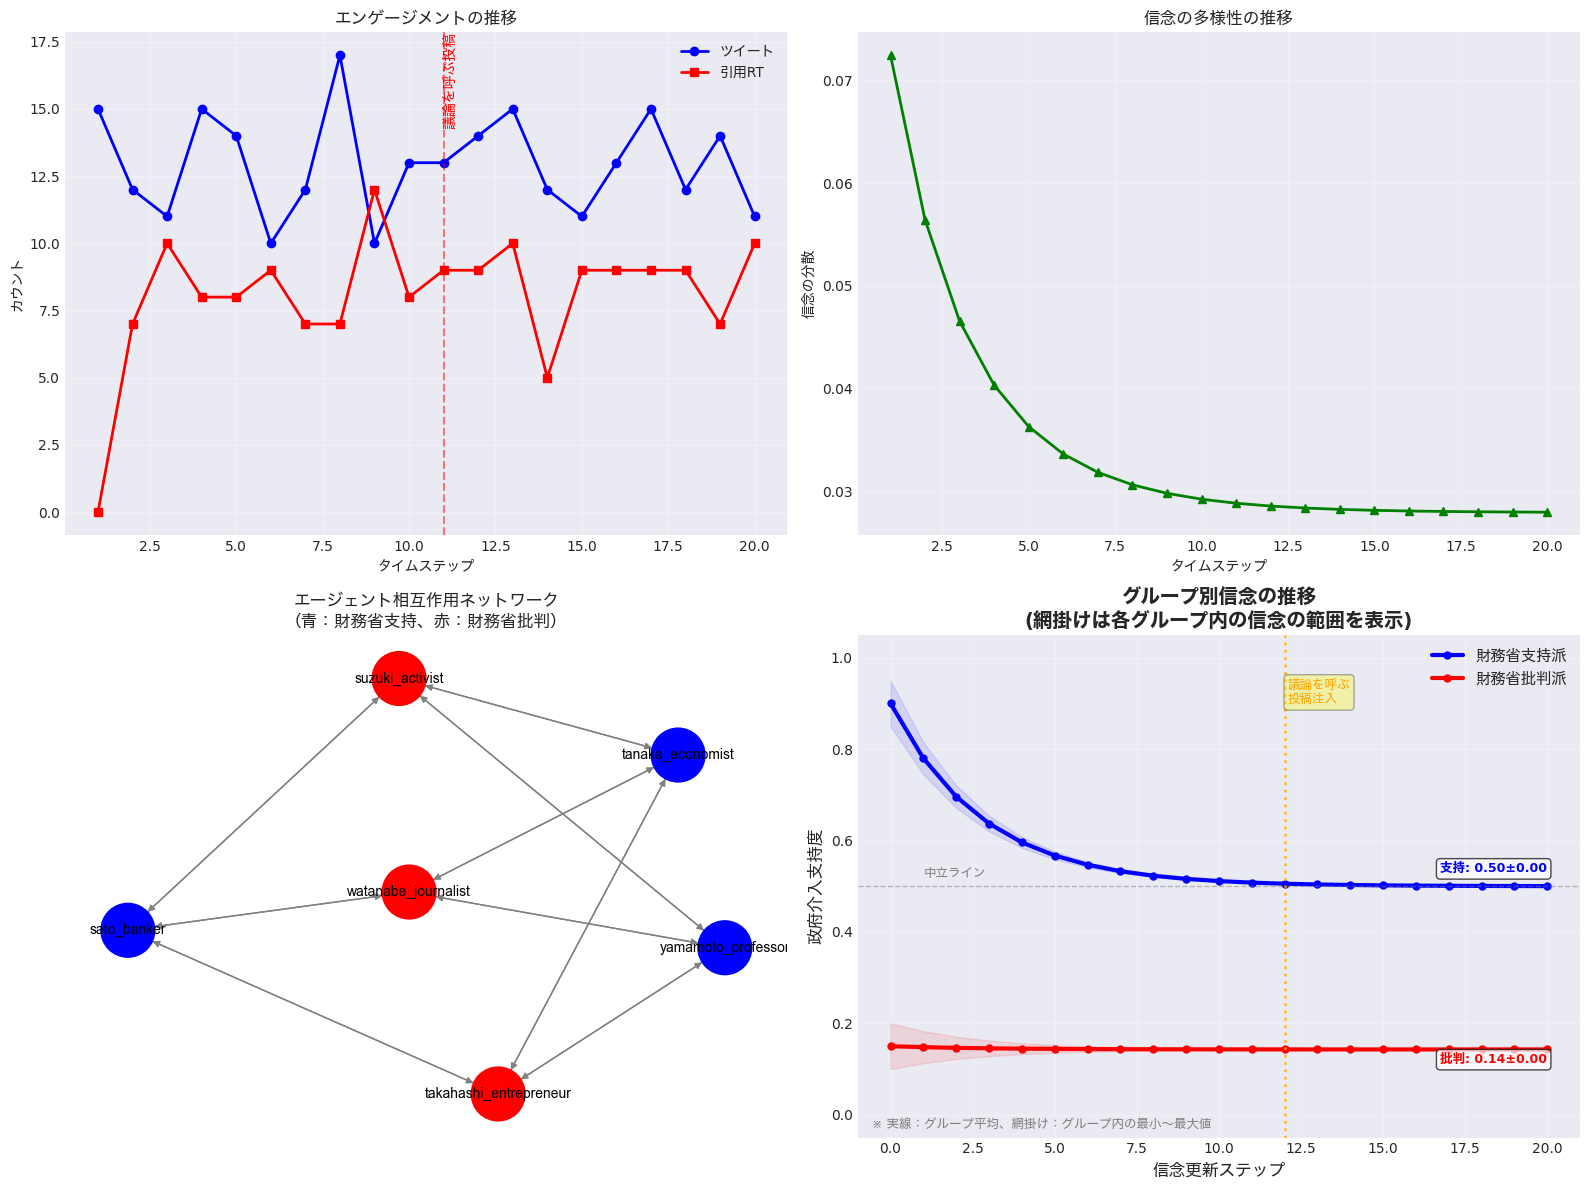

In [16]:
# Complete replacement for visualization Cell 8 with enhanced belief range visualization

# Standard visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Engagement over time
ax = axes[0, 0]
timesteps = range(1, len(simulation.metrics['tweets']) + 1)
ax.plot(timesteps, simulation.metrics['tweets'], 'b-o', label='ツイート', linewidth=2)
ax.plot(timesteps, simulation.metrics['quote_rts'], 'r-s', label='引用RT', linewidth=2)
ax.set_xlabel('タイムステップ')
ax.set_ylabel('カウント')
ax.set_title('エンゲージメントの推移')
ax.legend()
ax.grid(True, alpha=0.3)

# Mark provocative post injection
if simulation.provocative_post:
    ax.axvline(x=len(timesteps)//2 + 1, color='red', linestyle='--', alpha=0.5)
    ax.text(len(timesteps)//2 + 1, ax.get_ylim()[1], '議論を呼ぶ投稿', 
            rotation=90, va='top', color='red')

# 2. Belief variance
ax = axes[0, 1]
ax.plot(timesteps, simulation.metrics['belief_variance'], 'g-^', linewidth=2)
ax.set_xlabel('タイムステップ')
ax.set_ylabel('信念の分散')
ax.set_title('信念の多様性の推移')
ax.grid(True, alpha=0.3)

# 3. Network visualization
ax = axes[1, 0]
pos = nx.spring_layout(simulation.network, k=3, iterations=100)

# Color nodes by group
node_colors = []
for node in simulation.network.nodes():
    agent = next((a for a in simulation.agents if a.agent_id == node), None)
    if agent:
        if agent.group == "pro_mof":
            node_colors.append('blue')  # Pro-MOF in blue
        else:
            node_colors.append('red')   # Anti-MOF in red

nx.draw(simulation.network, pos, ax=ax,
        node_color=node_colors,
        node_size=1500,
        font_size=10,
        with_labels=True,
        edge_color='gray',
        arrows=True)

ax.set_title('エージェント相互作用ネットワーク\n（青：財務省支持、赤：財務省批判）')

# 4. Group belief evolution WITH BELIEF RANGE VISUALIZATION
ax = axes[1, 1]
pro_mof_agents = [a for a in simulation.agents if a.group == "pro_mof"]
anti_mof_agents = [a for a in simulation.agents if a.group == "anti_mof"]

# Process each group separately with shaded ranges
for group_agents, group_name, color in [(pro_mof_agents, '財務省支持派', 'blue'), 
                                        (anti_mof_agents, '財務省批判派', 'red')]:
    if not group_agents:
        continue
    
    # Find the maximum belief history length
    max_history = max(len(a.belief_history) for a in group_agents)
    
    # Prepare arrays for average and range of government intervention belief
    group_avg_beliefs = []
    group_min_beliefs = []
    group_max_beliefs = []
    
    for i in range(max_history):
        # Collect government intervention beliefs (index 0) for all agents at this timestep
        timestep_gov_beliefs = []
        
        for agent in group_agents:
            # Get belief at this timestep (or last available)
            idx = min(i, len(agent.belief_history) - 1)
            if idx >= 0 and len(agent.belief_history[idx]) > 0:
                # Get government intervention belief (index 0)
                timestep_gov_beliefs.append(agent.belief_history[idx][0])
        
        if timestep_gov_beliefs:
            # Calculate statistics for government intervention beliefs
            group_avg_beliefs.append(np.mean(timestep_gov_beliefs))
            group_min_beliefs.append(np.min(timestep_gov_beliefs))
            group_max_beliefs.append(np.max(timestep_gov_beliefs))
    
    # Convert to numpy arrays for plotting
    if group_avg_beliefs:  # Only plot if we have data
        time_points = np.arange(len(group_avg_beliefs))
        
        # Plot average line
        ax.plot(time_points, group_avg_beliefs, color=color, 
                label=group_name, linewidth=3, marker='o', markersize=5)
        
        # Add shaded area showing belief range within the group
        ax.fill_between(time_points, group_min_beliefs, group_max_beliefs, 
                        color=color, alpha=0.1)

# Add visual enhancements
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.text(1, 0.52, '中立ライン', fontsize=9, color='gray')

# Mark provocative post timing if exists
if simulation.provocative_post and max_history > 0:
    provocative_timestep = max_history // 2 + max_history // 10
    ax.axvline(x=provocative_timestep, color='orange', linestyle=':', alpha=0.7, linewidth=2)
    ax.text(provocative_timestep + 0.1, 0.9, '議論を呼ぶ\n投稿注入', 
            fontsize=9, color='orange', ha='left',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Add annotations for final values
for group_agents, group_name, color, y_offset in [(pro_mof_agents, '支持', 'blue', 0.03), 
                                                  (anti_mof_agents, '批判', 'red', -0.03)]:
    if group_agents and len(group_agents[0].belief_history) > 0:
        final_beliefs = [a.beliefs[0] for a in group_agents]
        final_avg = np.mean(final_beliefs)
        final_std = np.std(final_beliefs)
        
        # Annotate final average and spread
        ax.text(len(group_agents[0].belief_history) - 1, final_avg + y_offset, 
               f'{group_name}: {final_avg:.2f}±{final_std:.2f}', 
               fontsize=9, color=color, ha='right', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Styling
ax.set_xlabel('信念更新ステップ', fontsize=12)
ax.set_ylabel('政府介入支持度', fontsize=12)
ax.set_title('グループ別信念の推移\n(網掛けは各グループ内の信念の範囲を表示)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

# Add explanation text
ax.text(0.02, 0.02, '※ 実線：グループ平均、網掛け：グループ内の最小〜最大値', 
        transform=ax.transAxes, fontsize=9, color='gray', style='italic')

plt.tight_layout()
plt.show()


## 9. Viral Spread Visualization

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

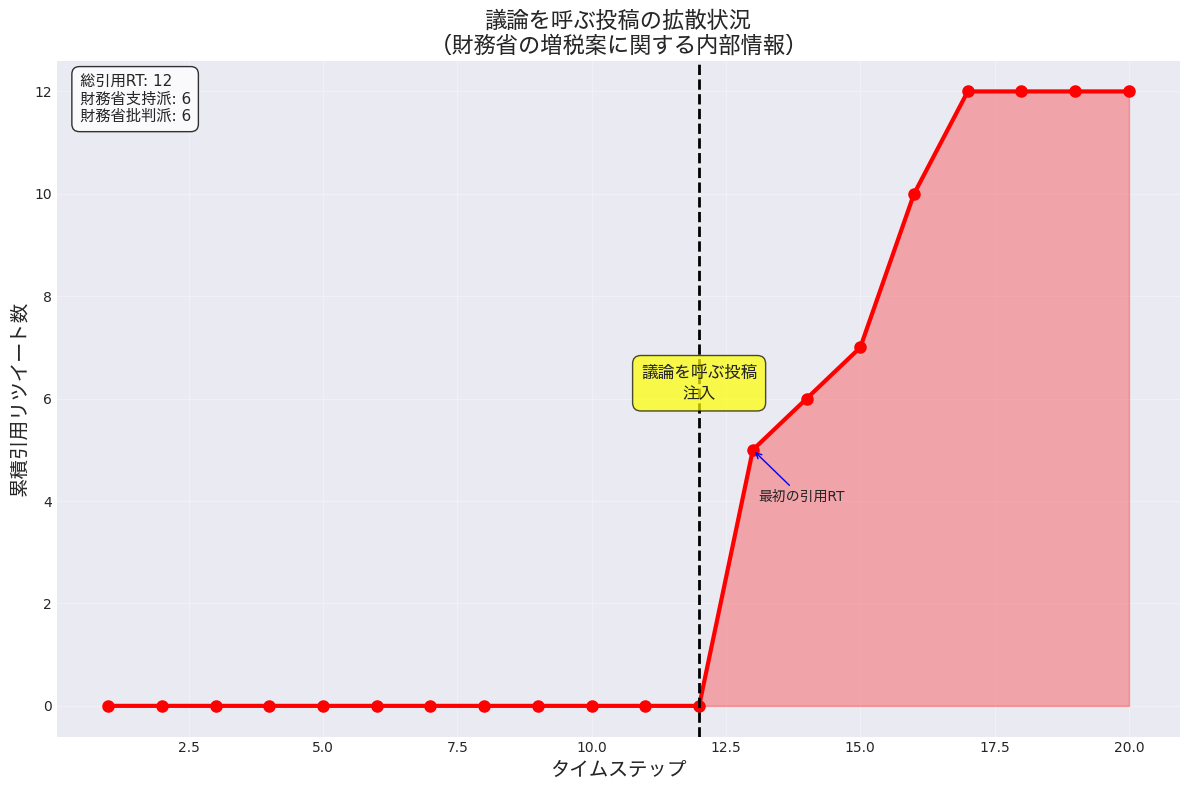


📝 議論を呼ぶ投稿への引用RTサンプル:

元の投稿: 【緊急】財務省が新たな増税案を検討中との内部情報。消費税15%への引き上げと、新たな『デジタル課税』の導入で、国民一人当たり年間50万円の負担増の試算。『財政健全化のため避けられない』との声明準備中。...

1. @tanaka_economist (支持派):
   "【完全同意】財政健全化こそ日本の未来！！これだけ社会保障費が膨らみ、高齢化が進む中で、増税は当たり前！将来世代にツケを回す方がよっぽど無責任です。「増税反対」と叫ぶ前に、日本社会の現実を直視してほしい..."

2. @sato_banker (支持派):
   "【完全同意！！】財務省の増税案、ついにここまで来たか。今こそ日本の未来のため、痛みを伴う改革が必要だ。財政赤字を放置すれば、我々だけでなく次世代が地獄を見る。増税反対派は現実逃避しているだけ。大胆な決..."

3. @yamamoto_professor (支持派):
   "やっと本気で日本の未来を考える動きが始まったことに拍手を送りたい！財政健全化なくして国の存続はない。消費税15％、デジタル課税――どちらも当然の一手！国民一人50万円の負担？将来世代への責任を果たすた..."

4. @takahashi_entrepreneur (批判派):
   "これは本気で許せない。消費税15%なんて冗談じゃないし、さらにデジタル課税で年間50万円も負担増？若者も事業者も潰す気か？「財政健全化」って言葉で国民の生活を破壊して何が未来だよ。こんな暴挙、国民を馬..."

5. @watanabe_journalist (批判派):
   "絶対に許せない！国民をこれ以上苦しめてどうするつもりだ。消費税15%に加えてデジタル課税？こんなの庶民イジメ以外の何物でもない！「財政健全化」という名の責任転嫁はもうやめろ。国会議員や官僚はまず自分た..."

6. @suzuki_activist (批判派):
   "絶対に許せません！国民の生活を何だと思ってるんですか！？これ以上の増税なんて、私たちの暮らしを完全に破壊しますよ！財政健全化の名の下に、弱い者いじめを続ける気ですか？断固反対！国民の声を無視するな！ ..."



In [14]:
# Viral spread visualization for the provocative post
plt.figure(figsize=(12, 8))

# Calculate cumulative quote RTs of the provocative post
if simulation.provocative_post:
    timesteps = range(1, len(simulation.metrics['provocative_qrts']) + 1)
    cumulative_qrts = simulation.metrics['provocative_qrts']
    
    # Main plot
    plt.plot(timesteps, cumulative_qrts, 'r-', linewidth=3, marker='o', markersize=8)
    
    # Fill area under curve
    plt.fill_between(timesteps, cumulative_qrts, alpha=0.3, color='red')
    
    # Mark injection point
    injection_point = len(timesteps) // 2 + len(timesteps) // 10
    plt.axvline(x=injection_point, color='black', linestyle='--', linewidth=2)
    plt.text(injection_point, max(cumulative_qrts)*0.5, 
            '議論を呼ぶ投稿\n注入', 
            ha='center', fontsize=12, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
    
    # Add annotations for key milestones
    if max(cumulative_qrts) > 0:
        # First quote RT
        first_qrt_idx = next((i for i, v in enumerate(cumulative_qrts) if v > 0), None)
        if first_qrt_idx is not None:
            plt.annotate('最初の引用RT', 
                        xy=(first_qrt_idx + 1, cumulative_qrts[first_qrt_idx]),
                        xytext=(first_qrt_idx + 1.1, cumulative_qrts[first_qrt_idx] - 1),
                        arrowprops=dict(arrowstyle='->', color='blue'))
    
    plt.xlabel('タイムステップ', fontsize=14)
    plt.ylabel('累積引用リツイート数', fontsize=14)
    plt.title('議論を呼ぶ投稿の拡散状況\n（財務省の増税案に関する内部情報）', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"総引用RT: {max(cumulative_qrts)}\n" \
                f"財務省支持派: {sum(1 for qrt in simulation.provocative_post_qrts if any(a.agent_id == qrt['author'] and a.group == 'pro_mof' for a in simulation.agents))}\n" \
                f"財務省批判派: {sum(1 for qrt in simulation.provocative_post_qrts if any(a.agent_id == qrt['author'] and a.group == 'anti_mof' for a in simulation.agents))}"
    
    plt.text(0.02, 0.98, stats_text, 
            transform=plt.gca().transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
            fontsize=11)
    
else:
    plt.text(0.5, 0.5, 'シミュレーションで議論を呼ぶ投稿が\n生成されませんでした', 
            ha='center', va='center', transform=plt.gca().transAxes,
            fontsize=14)

plt.tight_layout()
plt.show()

# Print sample quote RTs of the provocative post
if simulation.provocative_post_qrts:
    print("\n📝 議論を呼ぶ投稿への引用RTサンプル:")
    print("=" * 80)
    print(f"\n元の投稿: {simulation.provocative_post['content'][:100]}...\n")
    
    for i, qrt in enumerate(simulation.provocative_post_qrts[:6]):
        agent = next((a for a in simulation.agents if a.agent_id == qrt['author']), None)
        if agent:
            group_label = "支持派" if agent.group == "pro_mof" else "批判派"
            print(f"{i+1}. @{qrt['author']} ({group_label}):")
            print(f"   \"{qrt['content'][:100]}...\"")
            print()

## 10. Export Results

In [11]:
# Export simulation data
simulation_data = {
    'metadata': {
        'topic': simulation.topic,
        'num_agents': len(agents),
        'timesteps': len(simulation.metrics['tweets']),
        'groups': {
            'pro_mof': len([a for a in agents if a.group == 'pro_mof']),
            'anti_mof': len([a for a in agents if a.group == 'anti_mof'])
        },
        'timestamp': datetime.now().isoformat()
    },
    'provocative_post': {
        'content': simulation.provocative_post['content'] if simulation.provocative_post else None,
        'total_quote_rts': len(simulation.provocative_post_qrts),
        'injection_timestep': len(simulation.metrics['tweets']) // 2 + 1
    },
    'agents': [
        {
            'id': agent.agent_id,
            'personality': agent.personality,
            'group': agent.group,
            'initial_beliefs': agent.belief_history[0].tolist(),
            'final_beliefs': agent.beliefs.tolist(),
            'num_tweets': len(agent.tweet_history),
            'num_quote_rts': len(agent.quote_rt_history)
        }
        for agent in agents
    ],
    'metrics': simulation.metrics,
    'network': {
        'nodes': list(simulation.network.nodes()),
        'edges': list(simulation.network.edges()),
        'density': nx.density(simulation.network)
    }
}

# Save to file
filename = f"japanese_political_simulation_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(filename, 'w', encoding='utf-8') as f:
    json.dump(simulation_data, f, ensure_ascii=False, indent=2)

print(f"\n💾 シミュレーションデータを保存: {filename}")
print(f"\n✅ 日本政治言説CPCシミュレーション完了！")


💾 シミュレーションデータを保存: japanese_political_simulation_20250530_025319.json

✅ 日本政治言説CPCシミュレーション完了！
